In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

import utils

/home/ifled/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
#SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
#WORK_DIRECTORY = 'data'
#IMAGE_SIZE = 28
#NUM_CHANNELS = 1
#PIXEL_DEPTH = 255
#NUM_LABELS = 10
#VALIDATION_SIZE = 5000  # Size of the validation set.
#SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 200
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.
DATASET = 'cifar10'

NUM_UNROLL_STEPS = 5

### cifar10 baseline from tensorflow tutorial

In [5]:
# took architecture from here: https://github.com/tensorflow/models/blob/f798e4b5504b0b7ed08f7b7a03fc5a79f00b9f21/tutorials/image/cifar10/cifar10.py#L188

def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    
    if use_priors:
        projections = tf.layers.dense(inputs=prior, units=100, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=projections, units=num_units_after_conv, activation=tf.nn.sigmoid)
        
        gated = tf.multiply(pool2_flat, gates)
    else:
        gated = pool2_flat
    
    
    dense1 = tf.layers.dense(inputs=gated, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors

def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

## Use priors = False

In [6]:
use_priors = False

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history, stdout_lines = utils.run_train(apply, train_config, dataset,
                                        build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 33.5 ms
Minibatch loss: 10.859, learning rate: 0.001000
Minibatch error: [68.75, 68.75, 68.75, 68.75, 68.75]
Validation error: [83.4, 83.4, 83.4, 83.4, 83.4]
Step 100 (epoch 0.14), 110.3 ms
Minibatch loss: 7.960, learning rate: 0.001000
Minibatch error: [59.375, 59.375, 59.375, 59.375, 59.375]
Validation error: [55.8, 55.8, 55.8, 55.8, 55.8]
Step 200 (epoch 0.28), 110.3 ms
Minibatch loss: 6.922, learning rate: 0.001000
Minibatch error: [53.125, 53.125, 53.125, 53.125, 53.125]
Validation error: [52.42, 52.42, 52.42, 52.42, 52.42]
Step 300 (epoch 0.43), 110.2 ms
Minibatch loss: 6.005, learning rate: 0.001000
Minibatch error: [45.3125, 45.3125, 45.3125, 45.3125, 45.3125]
Validation error: [46.12, 46.12, 46.12, 46.12, 46.12]
Step 400 (epoch 0.57), 109.9 ms
Minibatch loss: 6.356, learning rate: 0.001000
Minibatch error: [43.75, 43.75, 43.75, 43.75, 43.75]
Validation error: [43.02, 43.02, 43.02, 43.02, 43.02]
Step 500 (epoch 0.71), 110.0 ms
Minibatch loss: 5

Step 3700 (epoch 5.26), 109.9 ms
Minibatch loss: 0.565, learning rate: 0.000774
Minibatch error: [3.125, 3.125, 3.125, 3.125, 3.125]
Validation error: [28.42, 28.42, 28.42, 28.42, 28.42]
Step 3800 (epoch 5.40), 109.9 ms
Minibatch loss: 1.258, learning rate: 0.000774
Minibatch error: [4.6875, 4.6875, 4.6875, 4.6875, 4.6875]
Validation error: [30.040000000000006, 30.040000000000006, 30.040000000000006, 30.040000000000006, 30.040000000000006]
Step 3900 (epoch 5.55), 110.1 ms
Minibatch loss: 0.732, learning rate: 0.000774
Minibatch error: [4.6875, 4.6875, 4.6875, 4.6875, 4.6875]
Validation error: [28.92, 28.92, 28.92, 28.92, 28.92]
Step 4000 (epoch 5.69), 110.0 ms
Minibatch loss: 0.811, learning rate: 0.000774
Minibatch error: [6.25, 6.25, 6.25, 6.25, 6.25]
Validation error: [28.799999999999997, 28.799999999999997, 28.799999999999997, 28.799999999999997, 28.799999999999997]
Step 4100 (epoch 5.83), 110.0 ms
Minibatch loss: 0.950, learning rate: 0.000774
Minibatch error: [4.6875, 4.6875, 4.6

Step 7400 (epoch 10.52), 110.0 ms
Minibatch loss: 0.065, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [28.92, 28.92, 28.92, 28.92, 28.92]
Step 7500 (epoch 10.67), 109.9 ms
Minibatch loss: 0.054, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [28.040000000000006, 28.040000000000006, 28.040000000000006, 28.040000000000006, 28.040000000000006]
Step 7600 (epoch 10.81), 110.0 ms
Minibatch loss: 0.094, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.620000000000005, 26.620000000000005, 26.620000000000005, 26.620000000000005, 26.620000000000005]
Step 7700 (epoch 10.95), 110.0 ms
Minibatch loss: 0.083, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.040000000000006, 27.040000000000006, 27.040000000000006, 27.040000000000006, 27.040000000000006]
Step 7800 (epoch 11.09), 110.0 ms
Minibatch loss: 0.164, learning rate: 0.000569
Minibatch er

Step 11000 (epoch 15.64), 110.1 ms
Minibatch loss: 0.078, learning rate: 0.000463
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [26.599999999999994, 26.599999999999994, 26.599999999999994, 26.599999999999994, 26.599999999999994]
Step 11100 (epoch 15.79), 110.0 ms
Minibatch loss: 0.017, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.659999999999997, 26.659999999999997, 26.659999999999997, 26.659999999999997, 26.659999999999997]
Step 11200 (epoch 15.93), 110.4 ms
Minibatch loss: 0.015, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.959999999999994, 26.959999999999994, 26.959999999999994, 26.959999999999994, 26.959999999999994]
Step 11300 (epoch 16.07), 110.3 ms
Minibatch loss: 0.052, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.439999999999998, 26.439999999999998, 26.439999999999998, 26.439999999999998, 26.439999999999998]
Step 1140

Step 15700 (epoch 22.33), 110.0 ms
Minibatch loss: 0.019, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.700000000000003, 26.700000000000003, 26.700000000000003, 26.700000000000003, 26.700000000000003]
Step 15800 (epoch 22.47), 110.1 ms
Minibatch loss: 0.026, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.060000000000002, 27.060000000000002, 27.060000000000002, 27.060000000000002, 27.060000000000002]
Step 15900 (epoch 22.61), 109.9 ms
Minibatch loss: 0.019, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.040000000000006, 26.040000000000006, 26.040000000000006, 26.040000000000006, 26.040000000000006]
Step 16000 (epoch 22.76), 110.3 ms
Minibatch loss: 0.003, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.439999999999998, 26.439999999999998, 26.439999999999998, 26.439999999999998, 26.439999999999998]
Step 16100 (epoch 22.90)

Step 19300 (epoch 27.45), 110.1 ms
Minibatch loss: 0.007, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.72, 25.72, 25.72, 25.72, 25.72]
Step 19400 (epoch 27.59), 110.0 ms
Minibatch loss: 0.009, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.14, 26.14, 26.14, 26.14, 26.14]
Step 19500 (epoch 27.73), 110.3 ms
Minibatch loss: 0.001, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.340000000000003, 26.340000000000003, 26.340000000000003, 26.340000000000003, 26.340000000000003]
Step 19600 (epoch 27.88), 110.1 ms
Minibatch loss: 0.006, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.260000000000005, 25.260000000000005, 25.260000000000005, 25.260000000000005]
Step 19700 (epoch 28.02), 110.2 ms
Minibatch loss: 0.005, learning rate: 0.000238
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.2999999

Step 23100 (epoch 32.85), 109.7 ms
Minibatch loss: 0.001, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.86, 25.86, 25.86, 25.86, 25.86]
Step 23200 (epoch 33.00), 110.2 ms
Minibatch loss: 0.002, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.64, 25.64, 25.64, 25.64, 25.64]
Step 23300 (epoch 33.14), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000184
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.599999999999994, 25.599999999999994, 25.599999999999994, 25.599999999999994, 25.599999999999994]
Step 23400 (epoch 33.28), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000184
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.099999999999994, 25.099999999999994, 25.099999999999994, 25.099999999999994, 25.099999999999994]
Step 23500 (epoch 33.42), 110.3 ms
Minibatch loss: 0.044, learning rate: 0.000184
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5600000

Step 26800 (epoch 38.12), 110.3 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.980000000000004, 24.980000000000004, 24.980000000000004, 24.980000000000004, 24.980000000000004]
Step 26900 (epoch 38.26), 110.3 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.959999999999994, 24.959999999999994, 24.959999999999994, 24.959999999999994, 24.959999999999994]
Step 27000 (epoch 38.40), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.900000000000006, 24.900000000000006, 24.900000000000006, 24.900000000000006, 24.900000000000006]
Step 27100 (epoch 38.54), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.900000000000006, 24.900000000000006, 24.900000000000006, 24.900000000000006, 24.900000000000006]
Step 27200 (epoch 38.68)

Step 30500 (epoch 43.38), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.659999999999997, 24.659999999999997, 24.659999999999997, 24.659999999999997, 24.659999999999997]
Step 30600 (epoch 43.52), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.58, 24.58, 24.58, 24.58, 24.58]
Step 30700 (epoch 43.66), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.78, 24.78, 24.78, 24.78]
Step 30800 (epoch 43.80), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.78, 24.78, 24.78, 24.78]
Step 30900 (epoch 43.95), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.739999999999995, 24.739999999999995, 24.739999999999995, 24.739999999999

Step 34300 (epoch 48.78), 109.4 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.599999999999994, 24.599999999999994, 24.599999999999994, 24.599999999999994, 24.599999999999994]
Step 34400 (epoch 48.92), 109.5 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.72, 24.72, 24.72, 24.72, 24.72]
Step 34500 (epoch 49.07), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000081
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.620000000000005, 24.620000000000005, 24.620000000000005, 24.620000000000005, 24.620000000000005]
Step 34600 (epoch 49.21), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000081
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.58, 24.58, 24.58, 24.58, 24.58]
Step 34700 (epoch 49.35), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000081
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.5400000

Step 38100 (epoch 54.19), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.620000000000005, 24.620000000000005, 24.620000000000005, 24.620000000000005, 24.620000000000005]
Step 38200 (epoch 54.33), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.599999999999994, 24.599999999999994, 24.599999999999994, 24.599999999999994, 24.599999999999994]
Step 38300 (epoch 54.47), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.599999999999994, 24.599999999999994, 24.599999999999994, 24.599999999999994, 24.599999999999994]
Step 38400 (epoch 54.61), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.599999999999994, 24.599999999999994, 24.599999999999994, 24.599999999999994, 24.599999999999994]
Step 38500 (epoch 54.76)

Step 41800 (epoch 59.45), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.560000000000002, 24.560000000000002, 24.560000000000002, 24.560000000000002, 24.560000000000002]
Step 41900 (epoch 59.59), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.620000000000005, 24.620000000000005, 24.620000000000005, 24.620000000000005, 24.620000000000005]
Step 42000 (epoch 59.73), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.58, 24.58, 24.58, 24.58, 24.58]
Step 42100 (epoch 59.88), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.64, 24.64, 24.64, 24.64, 24.64]
Step 42200 (epoch 60.02), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000046
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.5999999

Step 45600 (epoch 64.85), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.64, 24.64, 24.64, 24.64, 24.64]
Step 45700 (epoch 65.00), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.560000000000002, 24.560000000000002, 24.560000000000002, 24.560000000000002, 24.560000000000002]
Step 45800 (epoch 65.14), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000036
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.519999999999996, 24.519999999999996, 24.519999999999996, 24.519999999999996, 24.519999999999996]
Step 45900 (epoch 65.28), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000036
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.5, 24.5, 24.5, 24.5, 24.5]
Step 46000 (epoch 65.42), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000036
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.64, 24.64, 2

Step 49400 (epoch 70.26), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000028
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.560000000000002, 24.560000000000002, 24.560000000000002, 24.560000000000002, 24.560000000000002]
Step 49500 (epoch 70.40), 110.3 ms
Minibatch loss: 0.000, learning rate: 0.000028
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.519999999999996, 24.519999999999996, 24.519999999999996, 24.519999999999996, 24.519999999999996]
Step 49600 (epoch 70.54), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000028
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.620000000000005, 24.620000000000005, 24.620000000000005, 24.620000000000005, 24.620000000000005]
Step 49700 (epoch 70.68), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000028
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.700000000000003, 24.700000000000003, 24.700000000000003, 24.700000000000003, 24.700000000000003]
Step 49800 (epoch 70.83)

Step 53000 (epoch 75.38), 110.3 ms
Minibatch loss: 0.000, learning rate: 0.000021
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.659999999999997, 24.659999999999997, 24.659999999999997, 24.659999999999997, 24.659999999999997]
Step 53100 (epoch 75.52), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000021
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.799999999999997, 24.799999999999997, 24.799999999999997, 24.799999999999997, 24.799999999999997]
Step 53200 (epoch 75.66), 110.5 ms
Minibatch loss: 0.000, learning rate: 0.000021
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.739999999999995, 24.739999999999995, 24.739999999999995, 24.739999999999995, 24.739999999999995]
Step 53300 (epoch 75.80), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000021
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.78, 24.78, 24.78, 24.78]
Step 53400 (epoch 75.95), 110.3 ms
Minibatch loss: 0.000, learning rate: 0.000021
Minibat

Step 56700 (epoch 80.64), 110.5 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.739999999999995, 24.739999999999995, 24.739999999999995, 24.739999999999995, 24.739999999999995]
Step 56800 (epoch 80.78), 110.5 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.760000000000005, 24.760000000000005, 24.760000000000005, 24.760000000000005, 24.760000000000005]
Step 56900 (epoch 80.92), 110.5 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.659999999999997, 24.659999999999997, 24.659999999999997, 24.659999999999997, 24.659999999999997]
Step 57000 (epoch 81.07), 110.4 ms
Minibatch loss: 0.000, learning rate: 0.000016
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.739999999999995, 24.739999999999995, 24.739999999999995, 24.739999999999995, 24.739999999999995]
Step 57100 (epoch 81.21)

Step 60300 (epoch 85.76), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.86, 24.86, 24.86, 24.86]
Step 60400 (epoch 85.90), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.819999999999993, 24.819999999999993, 24.819999999999993, 24.819999999999993]
Step 60500 (epoch 86.04), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000012
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.879999999999995, 24.879999999999995, 24.879999999999995, 24.879999999999995]
Step 60600 (epoch 86.19), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000012
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.939999999999998, 24.939999999999998, 24.939999999999998, 24.939999999999998, 24.939999999999998]
Step 60700 (epoch 86.33), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000012
Minibat

Step 64000 (epoch 91.02), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000009
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.86, 24.86, 24.86, 24.86]
Step 64100 (epoch 91.16), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000009
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.939999999999998, 24.939999999999998, 24.939999999999998, 24.939999999999998, 24.939999999999998]
Step 64200 (epoch 91.31), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000009
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.040000000000006, 25.040000000000006, 25.040000000000006, 25.040000000000006, 25.040000000000006]
Step 64300 (epoch 91.45), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000009
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.959999999999994, 24.959999999999994, 24.959999999999994, 24.959999999999994, 24.959999999999994]
Step 64400 (epoch 91.59), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000009
Minibat

Step 67600 (epoch 96.14), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.040000000000006, 25.040000000000006, 25.040000000000006, 25.040000000000006, 25.040000000000006]
Step 67700 (epoch 96.28), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.22, 25.22, 25.22, 25.22, 25.22]
Step 67800 (epoch 96.43), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.040000000000006, 25.040000000000006, 25.040000000000006, 25.040000000000006, 25.040000000000006]
Step 67900 (epoch 96.57), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.159999999999997, 25.159999999999997, 25.159999999999997, 25.159999999999997, 25.159999999999997]
Step 68000 (epoch 96.71), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibat

Step 71200 (epoch 101.26), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.42, 25.42, 25.42, 25.42]
Step 71300 (epoch 101.40), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995]
Step 71400 (epoch 101.55), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.260000000000005, 25.260000000000005, 25.260000000000005, 25.260000000000005]
Step 71500 (epoch 101.69), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.260000000000005, 25.260000000000005, 25.260000000000005, 25.260000000000005]
Step 71600 (epoch 101.83), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000006
Mi

Step 74800 (epoch 106.38), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.340000000000003, 25.340000000000003, 25.340000000000003, 25.340000000000003, 25.340000000000003]
Step 74900 (epoch 106.52), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.299999999999997, 25.299999999999997, 25.299999999999997, 25.299999999999997, 25.299999999999997]
Step 75000 (epoch 106.67), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.28, 25.28, 25.28, 25.28, 25.28]
Step 75100 (epoch 106.81), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.22, 25.22, 25.22, 25.22, 25.22]
Step 75200 (epoch 106.95), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.23

Step 78400 (epoch 111.50), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36, 25.36, 25.36, 25.36, 25.36]
Step 78500 (epoch 111.64), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 78600 (epoch 111.79), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.28, 25.28, 25.28, 25.28, 25.28]
Step 78700 (epoch 111.93), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995]
Step 78800 (epoch 112.07), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.34

Step 82100 (epoch 116.76), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.42, 25.42, 25.42, 25.42]
Step 82200 (epoch 116.91), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.42, 25.42, 25.42, 25.42]
Step 82300 (epoch 117.05), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.42, 25.42, 25.42, 25.42]
Step 82400 (epoch 117.19), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36, 25.36, 25.36, 25.36, 25.36]
Step 82500 (epoch 117.33), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 82600 (epoch 117.48), 109.7 ms

Step 85800 (epoch 122.03), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.42, 25.42, 25.42, 25.42]
Step 85900 (epoch 122.17), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995]
Step 86000 (epoch 122.31), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 86100 (epoch 122.45), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 86200 (epoch 122.60), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000002
Mi

Step 89600 (epoch 127.43), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36, 25.36, 25.36, 25.36, 25.36]
Step 89700 (epoch 127.57), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995]
Step 89800 (epoch 127.72), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.42, 25.42, 25.42, 25.42]
Step 89900 (epoch 127.86), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995, 25.379999999999995]
Step 90000 (epoch 128.00), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36

Step 93300 (epoch 132.69), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998]
Step 93400 (epoch 132.84), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.400000000000006, 25.400000000000006, 25.400000000000006, 25.400000000000006, 25.400000000000006]
Step 93500 (epoch 132.98), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 93600 (epoch 133.12), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.42, 25.42, 25.42, 25.42]
Step 93700 (epoch 133.26), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000001
Mi

Step 96900 (epoch 137.81), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 97000 (epoch 137.96), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 97100 (epoch 138.10), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998]
Step 97200 (epoch 138.24), 110.3 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998]
Step 97300 (epoch 13

Step 100600 (epoch 143.08), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 100700 (epoch 143.22), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 100800 (epoch 143.36), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.400000000000006, 25.400000000000006, 25.400000000000006, 25.400000000000006, 25.400000000000006]
Step 100900 (epoch 143.50), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.400000000000006, 25.400000000000006, 25.400000000000006, 25.400000000000006, 25.400000000000006]
Step 101000 (epo

Step 104100 (epoch 148.05), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998]
Step 104200 (epoch 148.20), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 104300 (epoch 148.34), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998, 25.439999999999998]
Step 104400 (epoch 148.48), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 104500 (epo

Step 107600 (epoch 153.03), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994, 25.459999999999994]
Step 107700 (epoch 153.17), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.5, 25.5, 25.5, 25.5]
Step 107800 (epoch 153.32), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 107900 (epoch 153.46), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 108000 (epoch 153.60), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000000
Mi

Step 111100 (epoch 158.01), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 111200 (epoch 158.15), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.5, 25.5, 25.5, 25.5]
Step 111300 (epoch 158.29), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 111400 (epoch 158.44), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 111500 (epoch 158.58), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Mi

Step 114900 (epoch 163.41), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.5, 25.5, 25.5, 25.5]
Step 115000 (epoch 163.56), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.5, 25.5, 25.5, 25.5]
Step 115100 (epoch 163.70), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.5, 25.5, 25.5, 25.5]
Step 115200 (epoch 163.84), 110.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.5, 25.5, 25.5, 25.5]
Step 115300 (epoch 163.98), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.5, 25.5, 25.5, 25.5]
Step 115400 (epoch 164.12), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0

Step 119600 (epoch 170.10), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 119700 (epoch 170.24), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 119800 (epoch 170.38), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 119900 (epoch 170.52), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.5, 25.5, 25.5, 25.5]
Step 120000 (epoch 170.67), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Mi

Step 123000 (epoch 174.93), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 123100 (epoch 175.08), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 123200 (epoch 175.22), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 123300 (epoch 175.36), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 123400 (epo

Step 126400 (epoch 179.77), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 126500 (epoch 179.91), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 126600 (epoch 180.05), 109.6 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 126700 (epoch 180.20), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 126800 (epo

Step 129800 (epoch 184.60), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 129900 (epoch 184.75), 110.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 130000 (epoch 184.89), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 130100 (epoch 185.03), 109.7 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 130200 (epo

Step 133200 (epoch 189.44), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 133300 (epoch 189.58), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 133400 (epoch 189.72), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 133500 (epoch 189.87), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 133600 (epo

Step 136600 (epoch 194.28), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 136700 (epoch 194.42), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 136800 (epoch 194.56), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 136900 (epoch 194.70), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 137000 (epo

Step 140000 (epoch 199.11), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 140100 (epoch 199.25), 109.8 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 140200 (epoch 199.40), 109.9 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 140300 (epoch 199.54), 110.0 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004, 25.480000000000004]
Step 140400 (epo

In [7]:
test_error, train_metrics = history
losses, lrs, train_errors, val_erors = zip(*train_metrics)

In [8]:
from matplotlib import pyplot

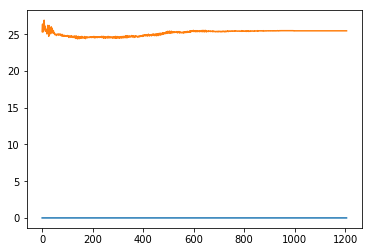

In [11]:
pyplot.plot(np.array(train_errors)[200:, 0])
pyplot.plot(np.array(val_erors)[200:, 0])

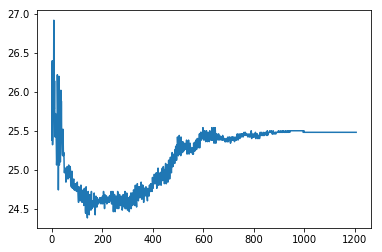

In [12]:
pyplot.plot(np.array(val_erors)[200:, 0])